In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold
from sklearn import linear_model, metrics, preprocessing
from sklearn.feature_selection import RFE,SelectPercentile,f_classif,chi2
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

### Load data

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

skf_cv = StratifiedKFold(df_train['TARGET'], n_folds=6, shuffle=True, random_state=None) # split target equally
def score_model(model,X,t):
    #return cross_val_score(model, X, t, cv=6, scoring="roc_auc",n_jobs=3)
    return cross_val_score(model, X, t, cv=skf_cv, scoring="roc_auc",n_jobs=4)

### Remove constant columns

In [3]:
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Remove duplicated columns

In [4]:
remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Other cleaning

In [5]:
# Replace -999999 in var3 column with most common value 2 
df_train = df_train.replace(-999999,2)
df_test = df_test.replace(-999999,2)

### Feature selection

In [6]:
Xdf_tr = df_train.drop('TARGET', 1)
tdf_tr = df_train.TARGET

from sklearn.preprocessing import Binarizer, scale

p = 50 # percentage of selected features

X_bin = Binarizer().fit_transform(scale(Xdf_tr))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, tdf_tr)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(Xdf_tr, tdf_tr)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if chi2_selected[i]]

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if f_classif_selected[i]]


selected = chi2_selected | f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(Xdf_tr.columns, selected) if s]

print('List of features:{}'.format(features))
Xdf=df_train[features]

Chi2 & F_classif selected 173 features
List of features:['var3', 'var15', 'imp_op_var39_comer_ult1', 'imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var41_comer_ult1', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'imp_sal_var16_ult1', 'ind_var1', 'ind_var5_0', 'ind_var5', 'ind_var8_0', 'ind_var8', 'ind_var12_0', 'ind_var12', 'ind_var13_0', 'ind_var13_corto_0', 'ind_var13_corto', 'ind_var13_largo_0', 'ind_var13_largo', 'ind_var13', 'ind_var14_0', 'ind_var14', 'ind_var17_0', 'ind_var19', 'ind_var20_0', 'ind_var20', 'ind_var24_0', 'ind_var24', 'ind_var25_cte', 'ind_var26_0', 'ind_var26_cte', 'ind_var25_0', 'ind_var30_0', 'ind_var30', 'ind_var31_0', 'ind_var31', 'ind_var33_0', 'ind_var33', 'ind_var39_0', 'ind_var40', 'ind_var41_0', 'ind_var44_0', 'num_var1', 'num_var4', 'num_var5_0', 'num_var5', 'num_var8_0', 'num_var8', 'num_var12_0', 'num_var12', 'num_var13_0', 'num_var1

/home/nguyen/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


### Extract training data

In [7]:
# classifier
# http://xgboost.readthedocs.org/en/latest/parameter.html
# http://xgboost.readthedocs.org/en/latest/param_tuning.html
clf = xgb.XGBClassifier(
      objective= 'binary:logistic',    
      learning_rate=0.0175, 
      n_estimators=500,
      max_depth=8,
      subsample=0.9,
      colsample_bytree=0.87,
      nthread=4,
      silent = 1,
      seed=8
)
# best observed: learning_rate=0.0175, n_estimators=400,max_depth=8,subsample=0.9,colsample_bytree=0.87,  seed=8

X_tr = Xdf.as_matrix()
t_tr = df_train['TARGET'].as_matrix()

cv_scores={}
cv_scores['XGB']=score_model(clf, X_tr,t_tr)
print cv_scores

{'XGB': array([ 0.84632642,  0.84938658,  0.83402289,  0.8229484 ,  0.84665998,
        0.8328258 ])}


In [8]:
# Split up the data for early stopping
X_fit, X_eval, t_fit, t_eval = train_test_split(X_tr, t_tr, test_size=0.25, random_state=42)

clf.fit(X_tr, t_tr, early_stopping_rounds=50, eval_metric="auc", eval_set=[(X_eval, t_eval)])

Will train until validation_0 error hasn't decreased in 50 rounds.
[0]	validation_0-auc:0.722941
[1]	validation_0-auc:0.779546
[2]	validation_0-auc:0.802952
[3]	validation_0-auc:0.807800
[4]	validation_0-auc:0.810315
[5]	validation_0-auc:0.812878
[6]	validation_0-auc:0.808239
[7]	validation_0-auc:0.805520
[8]	validation_0-auc:0.807389
[9]	validation_0-auc:0.800781
[10]	validation_0-auc:0.805410
[11]	validation_0-auc:0.804760
[12]	validation_0-auc:0.805456
[13]	validation_0-auc:0.802444
[14]	validation_0-auc:0.805087
[15]	validation_0-auc:0.807573
[16]	validation_0-auc:0.809231
[17]	validation_0-auc:0.810527
[18]	validation_0-auc:0.811754
[19]	validation_0-auc:0.814438
[20]	validation_0-auc:0.814711
[21]	validation_0-auc:0.815693
[22]	validation_0-auc:0.816347
[23]	validation_0-auc:0.816673
[24]	validation_0-auc:0.816869
[25]	validation_0-auc:0.817856
[26]	validation_0-auc:0.818504
[27]	validation_0-auc:0.818897
[28]	validation_0-auc:0.819453
[29]	validation_0-auc:0.819210
[30]	validati

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.87,
       gamma=0, learning_rate=0.0175, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=None, n_estimators=500, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=8, silent=1, subsample=0.9)

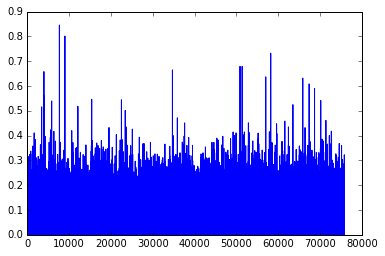

In [9]:
X_test = df_test[features].as_matrix()
t_pred=clf.predict_proba(X_test)[:,1]
plt.plot(t_pred)

id_test = df_test['ID']
submission = pd.DataFrame({"ID":id_test, "TARGET": t_pred})
submission.to_csv("./data/submission_xgb.csv", index=False)